In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [2]:
model = InceptionV3(include_top=True, weights='imagenet')
model.trainable = False # freeze model parameters

# read and preprocess image data
def preprocess(image_path):
    image_raw = tf.io.read_file(image_path) # read data from file
    image = tf.image.decode_image(image_raw) # decode to image
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (299, 299))
    image = preprocess_input(image) # zero-centered
    image = image[None, ...] # expand batch dim
    return image

x_input = preprocess('coffee.png')
preds = model.predict(x_input)

# decode the results into a list of tuples (class_num, description, probability)
def get_imagenet_label(preds):
    return decode_predictions(preds, top=1)[0][0]

print('Predicted:', get_imagenet_label(preds))

Predicted: ('n07920052', 'espresso', 0.9874177)


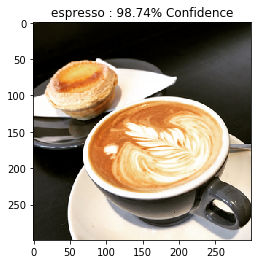

In [3]:
plt.figure()
plt.imshow(x_input[0]*0.5+0.5) # To change [-1, 1] to [0,1]
class_num, description, probability = get_imagenet_label(preds)
plt.title('{} : {:.2f}% Confidence'.format(description, probability*100))
plt.show()

In [4]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

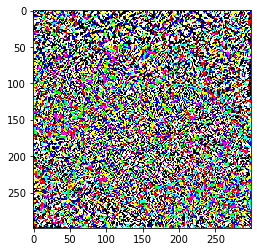

In [5]:
# Get the input label of the image.
label_index = preds.argmax()
label = tf.one_hot(label_index, preds.shape[-1])
label = tf.reshape(label, (1, preds.shape[-1]))

perturbations = create_adversarial_pattern(x_input, label)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

In [6]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
    plt.show()

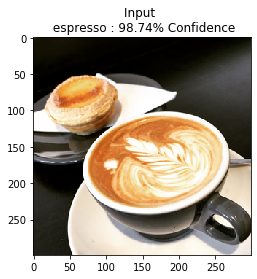

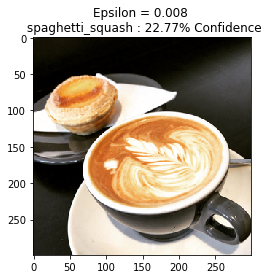

In [7]:
epsilons = [0, 2/255]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = x_input + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])